# DeBERTa-v3 

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics
)

### Setup


In [3]:
MODEL_NAME = "deberta_v3" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
DATA_PATH = "../data/data_multiclass_with_none_large.csv"
MODEL_PATH = "microsoft/deberta-v3-base"
MODEL_TRAINING_PATH ="microsoft/deberta-v3-small"
OUTPUT_DIR = "../models/deberta_v3_multi_large_huggingface/trainer_output"
SAVE_PATH = "../models/deberta_v3_multi_large_huggingface/huggingface_model"

### Get data

In [5]:
# use "binary" for binary classification and "multiclass" for multiclass classification
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data("multiclass", DATA_PATH, MODEL_PATH)

2025-04-23 11:48:26,315: Loading data...
2025-04-23 11:48:26,339: Train test split, test-size 0.3
2025-04-23 11:48:26,345: Create encoded dataframes
2025-04-23 11:48:26,346: Encode the label column
2025-04-23 11:48:26,347: Tokenize
2025-04-23 11:48:26,347: create tokenizer & load model
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
2025-04-23 11:48:28,264: create tokenizer & load model
2025-04-23 11:48:29,288: Create TextDatasets (

In [6]:
y_train = encoded_train_dataset['logical_fallacies']

### Zero Shot Inference 

In [7]:
# # disable upper limit for memory
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# # Allows up to 100% of available memory
# torch.mps.set_per_process_memory_fraction(1.0)  

# torch.mps.empty_cache()  # Clears unused GPU memory

In [8]:
# # Load fresh copy of base model (not train on our data)
# num_classes = len(df["logical_fallacies"].unique())
# base_model = AutoModelForSequenceClassification.from_pretrained(
#     "microsoft/deberta-v3-small",
#     num_labels=num_classes,
#     problem_type="single_label_classification"
# )

In [9]:
# def predict(model, encodings, batch_size=8):
#     # Set the model to evaluation mode
#     model.eval()
    
#     # Use GPU
#     device = torch.device("mps")
#     model.to(device)
    
#     # Perform inference
#     probabilities = []
#     for i in range(0, len(encodings["input_ids"]), batch_size):
#         with torch.no_grad():
#             batch = {
#                 "input_ids": encodings["input_ids"][i:i+batch_size].to(device),
#                 "attention_mask": encodings["attention_mask"][i:i+batch_size].to(device)
#             }
#             outputs = model(**batch)
#             probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
#             probabilities.extend(probs)
            
#         # Clear GPU memory after each batch
#         torch.mps.empty_cache()
    
#     return np.array(probabilities)

In [10]:
# # Get predictions for test data
# base_probs = predict(base_model, test_encodings, batch_size=8)

In [11]:
# # Get highest probability indices
# predicted_indices = np.argmax(base_probs, axis=1)  

In [12]:
# from sklearn.metrics import classification_report

# # Generate classification report
# report = classification_report(y_test, predicted_indices, target_names=le.classes_)
# print(report)

Note: This deberta model is actually not designed for zero shot, there is one by MoritzLauer which can be used without requiring training on data. So training on data is actually necessary! The DeBERTa used here is meant for supervised learning. 
Another option is to use BART, facebook/bart-large-mnli model.

**Zero-Shot Learning** </span> is a concept, that a model when trained on enough unlabeled data (unsupervised learning) is able to generalize/ recognize at inference time even though the model was not trained on the inference data. This can be used in NLP, Images etc.

### Model Initialization

I had to change configuration of accelerate, as it might still be configured to fp16 (mixed precision)(doesn't work on Apple M1 Pro):
- type in bash accelerate config
- this machine
- no distributed training
- do you want to run your training on CPU only, say No, as MAC Apple M1 Pro has GPU
- do you wish to optimize script with torch dynamo: say "No" if using an Apple M1 Pro with MPS backend
- do you want to use mixed precision: NO

In [13]:
learning_rate= 2e-5
weight_decay= 0.01
num_train_epochs= 3
evaluation_strategy= 'epoch'
class_weight=False
dropout=None


params = {
     "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }
  
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag('mlflow.runName', 'deberta_v3_multiclass_huggingface')
mlflow.log_params(params)

Active run_id: db54c1f00e3545e290d199c4856e0eb2


In [14]:
num_classes = len(np.unique(y_train))
num_classes

6

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    num_labels=num_classes,
    problem_type="single_label_classification"
)

model.gradient_checkpointing_enable()  # force model to use gradient checkpointing to save memory

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, #standard for deberta; maybe try 6e-6
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

2025-04-23 11:48:30,316: defining training arguments
2025-04-23 11:48:30,339: get normal trainer


### Execute Training

In [17]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [18]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [19]:
logger.info('training is running')
trainer.train()

2025-04-23 11:48:30,933: training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,0.903100,0.828326,0.716296
2,0.777500,0.823554,0.764444
3,0.443100,0.964645,0.777778


TrainOutput(global_step=2364, training_loss=0.7455745868876501, metrics={'train_runtime': 3581.8805, 'train_samples_per_second': 2.638, 'train_steps_per_second': 0.66, 'total_flos': 1251950805504000.0, 'train_loss': 0.7455745868876501, 'epoch': 3.0})

### Evaluation

In [20]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

2025-04-23 12:48:13,086: predict on train_dataset


2025-04-23 12:58:13,905: get evaluation metrics
2025-04-23 12:58:13,912: classification_report
2025-04-23 12:58:13,934: confusion_matrix
2025-04-23 12:58:13,942: heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.95      0.85      0.90       545
appeal_to_authority       0.90      0.93      0.92       508
  appeal_to_emotion       0.86      0.89      0.87       592
      false_dilemma       0.94      0.84      0.88       541
               none       0.79      0.91      0.84       525
     slippery_slope       0.92      0.95      0.94       439

           accuracy                           0.89      3150
          macro avg       0.90      0.89      0.89      3150
       weighted avg       0.89      0.89      0.89      3150



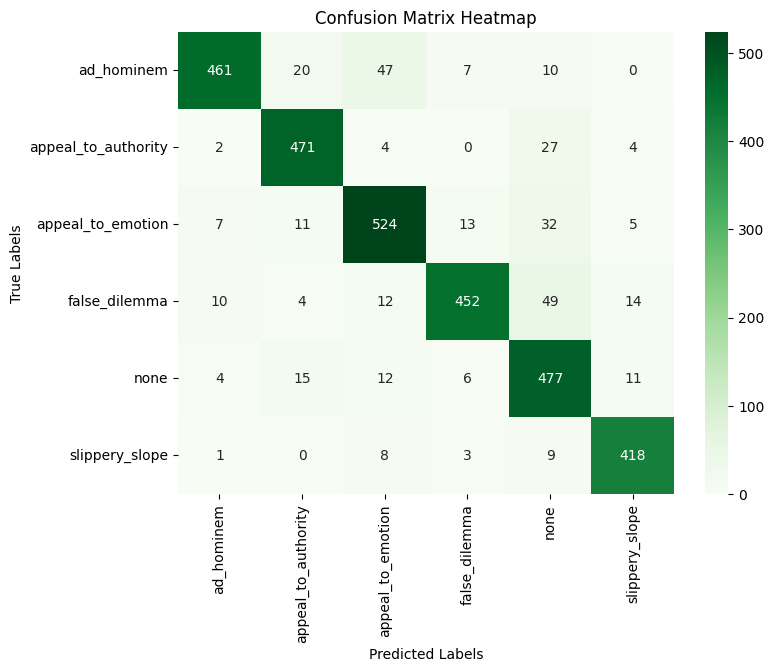

2025-04-23 12:58:14,345: brier score


Multiclass Brier score: 0.1692781481842746


In [21]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")

2025-04-23 12:58:14,619: predict on test_dataset


2025-04-23 12:59:25,439: get evaluation metrics
2025-04-23 12:59:25,443: classification_report
2025-04-23 12:59:25,460: confusion_matrix
2025-04-23 12:59:25,477: heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.83      0.73      0.78       233
appeal_to_authority       0.81      0.80      0.81       218
  appeal_to_emotion       0.68      0.73      0.70       254
      false_dilemma       0.87      0.79      0.83       232
               none       0.61      0.71      0.65       225
     slippery_slope       0.86      0.84      0.85       188

           accuracy                           0.76      1350
          macro avg       0.78      0.77      0.77      1350
       weighted avg       0.77      0.76      0.77      1350



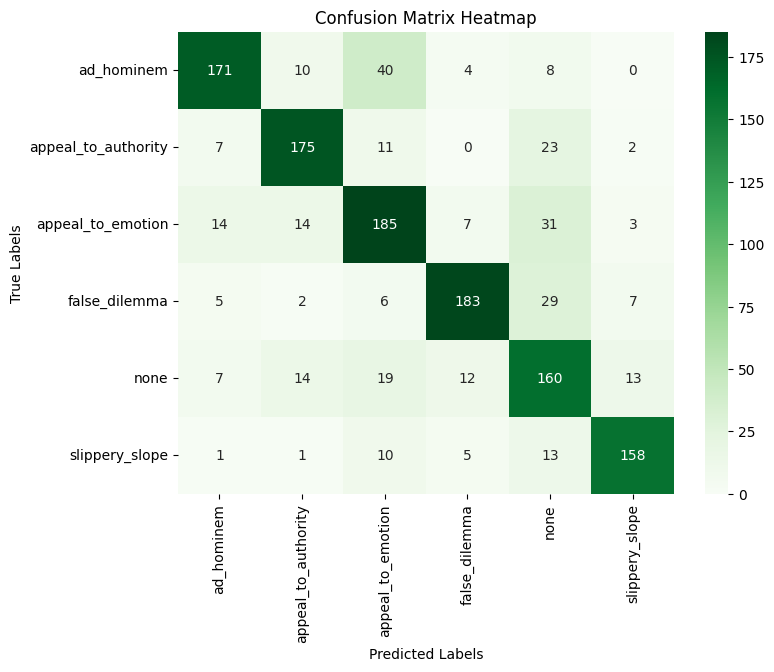

2025-04-23 12:59:25,628: brier score


Multiclass Brier score: 0.3689877311076725


In [22]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")

In [23]:
mlflow.end_run()

🏃 View run deberta_v3_multiclass_huggingface at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/db54c1f00e3545e290d199c4856e0eb2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [26]:
#save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

### Save for Huggingface

In [25]:
from transformers import AutoTokenizer

# Save the model
model.save_pretrained(OUTPUT_DIR)

# Save the tokenizer (if you're using it)
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
tokenizer.save_pretrained(OUTPUT_DIR)


/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


('../models/deberta_v3_multi_large_huggingface/trainer_output/tokenizer_config.json',
 '../models/deberta_v3_multi_large_huggingface/trainer_output/special_tokens_map.json',
 '../models/deberta_v3_multi_large_huggingface/trainer_output/spm.model',
 '../models/deberta_v3_multi_large_huggingface/trainer_output/added_tokens.json',
 '../models/deberta_v3_multi_large_huggingface/trainer_output/tokenizer.json')